## Simulating LSST-like image time-series of lensed type Ia supernovae

### Import python libraries, LSST characteristics and functions

In [1]:
import pickle as pickle
from class_telescope import Telescope
from image_time_series import simulate_time_series_images
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.rc("font", family="serif")
plt.rc("text", usetex=True)

### Parameter distributions 

Sample $z_l$, $z_s$ and $\theta_E$ from MC sample from Wojtak et al. (2019).


In [2]:
# ---------------------------------
telescope = 'LSST'
bandpasses = ['r', 'i', 'z', 'y']
num_samples = 1000
# ---------------------------------

lsst = Telescope(telescope, bandpasses, num_samples)


Setting up OpSim Summary generator...
 reading from database sqlite:///../data/OpSim_databases/baseline_v3.0_10yrs.db
We have filterNull set to False
checking that summary table read in

Reading in raw tables successful
replacing names works
dropping duplicates works
dithered column names exists 
Changing units for fbsv2 from degrees


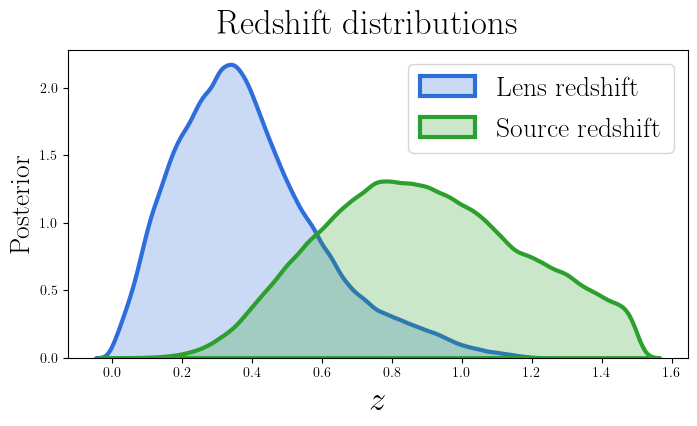

In [3]:
lsst.plot_redshifts()

### Seeing distributions
Sample the PSF from the predicted seeing distribution for the <b> baseline v2.0 </b> observing strategy for 10 years.

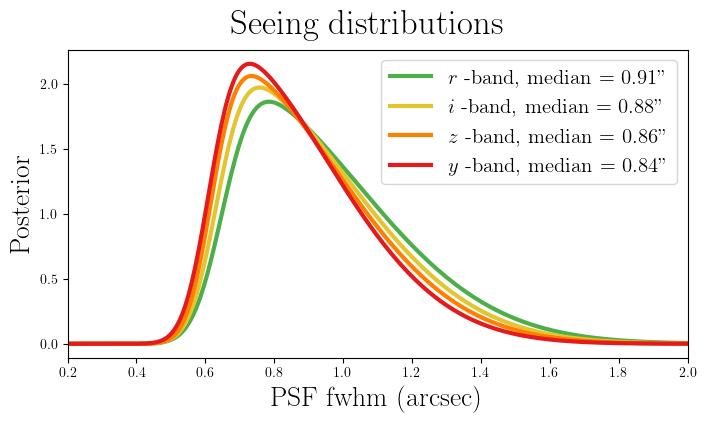

In [4]:
lsst.plot_seeing_distributions()


### Cadence

Sample the cadence from the predicted distribution for the <b> baseline v2.0 </b> observing strategy for the LSST Wide, Fast, Deep survey from Catarina Alves' simulations.


In [5]:
# lsst.plot_cadence()


### Generation of training and test sets


  0%|                                                                | 0/1 [00:00<?, ?it/s]

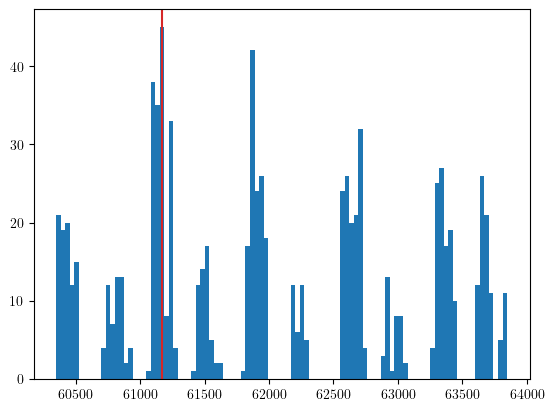

Theoretically visible with image multiplicity method?            True
Theoretically visible with magnification method?                 False
Observations allow for detection with image multiplicity method? True
Observations allow for detection with magnification method?      False
 
Lens redshift:  0.1
Supernova redshift:  0.68
Einstein radius:  0.78
Time delays:  [0.   0.92 0.94 2.63] days
Macro magnification:  [ 4.24 12.92 11.66  2.11]
Microlensing contribution at peak (magnitudes):  0.0
Hubble constant:  67.8
Time-delay distance:  518.87
Peak brightness images for r,i,z,y bands:
[[22.   20.76 20.89 22.71]
 [21.69 20.49 20.59 22.36]
 [21.8  20.64 20.74 22.71]
 [21.58 20.38 20.5  22.05]]
 


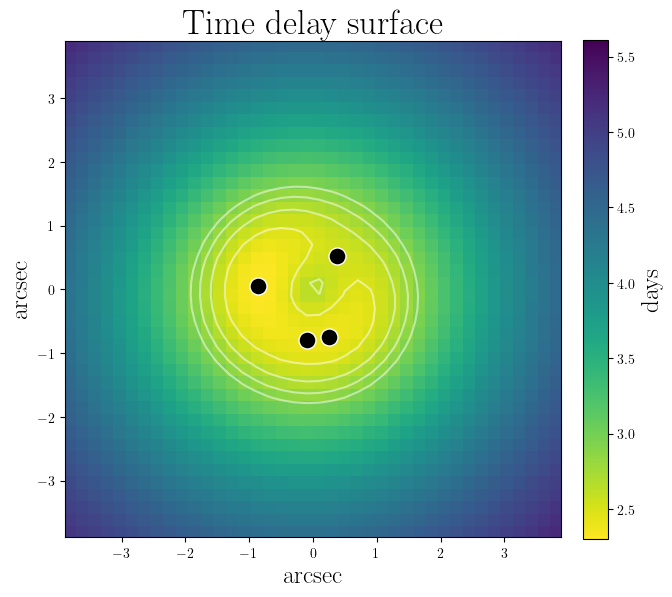

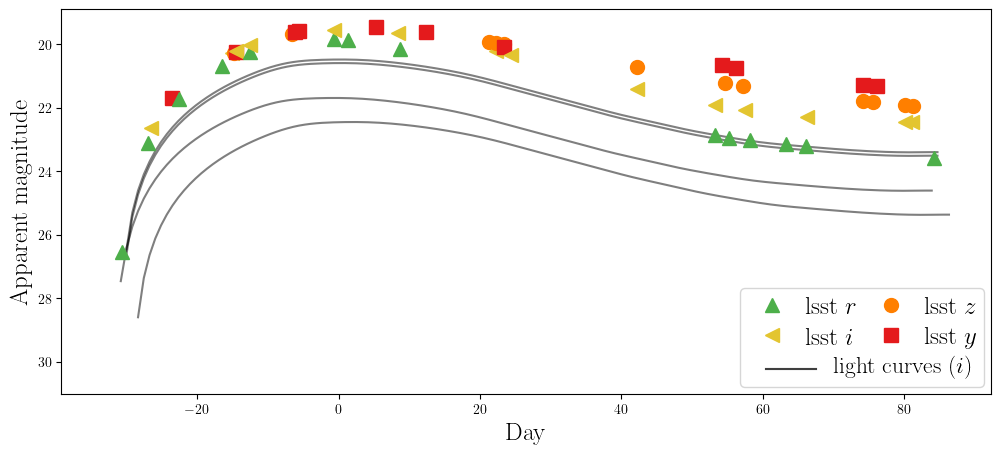

33.0184584618168 19.746992847839763
31.475695462995944 19.479998107579945
37.21407138878559 19.529046752649254
31.3206319433557 19.383361456241737


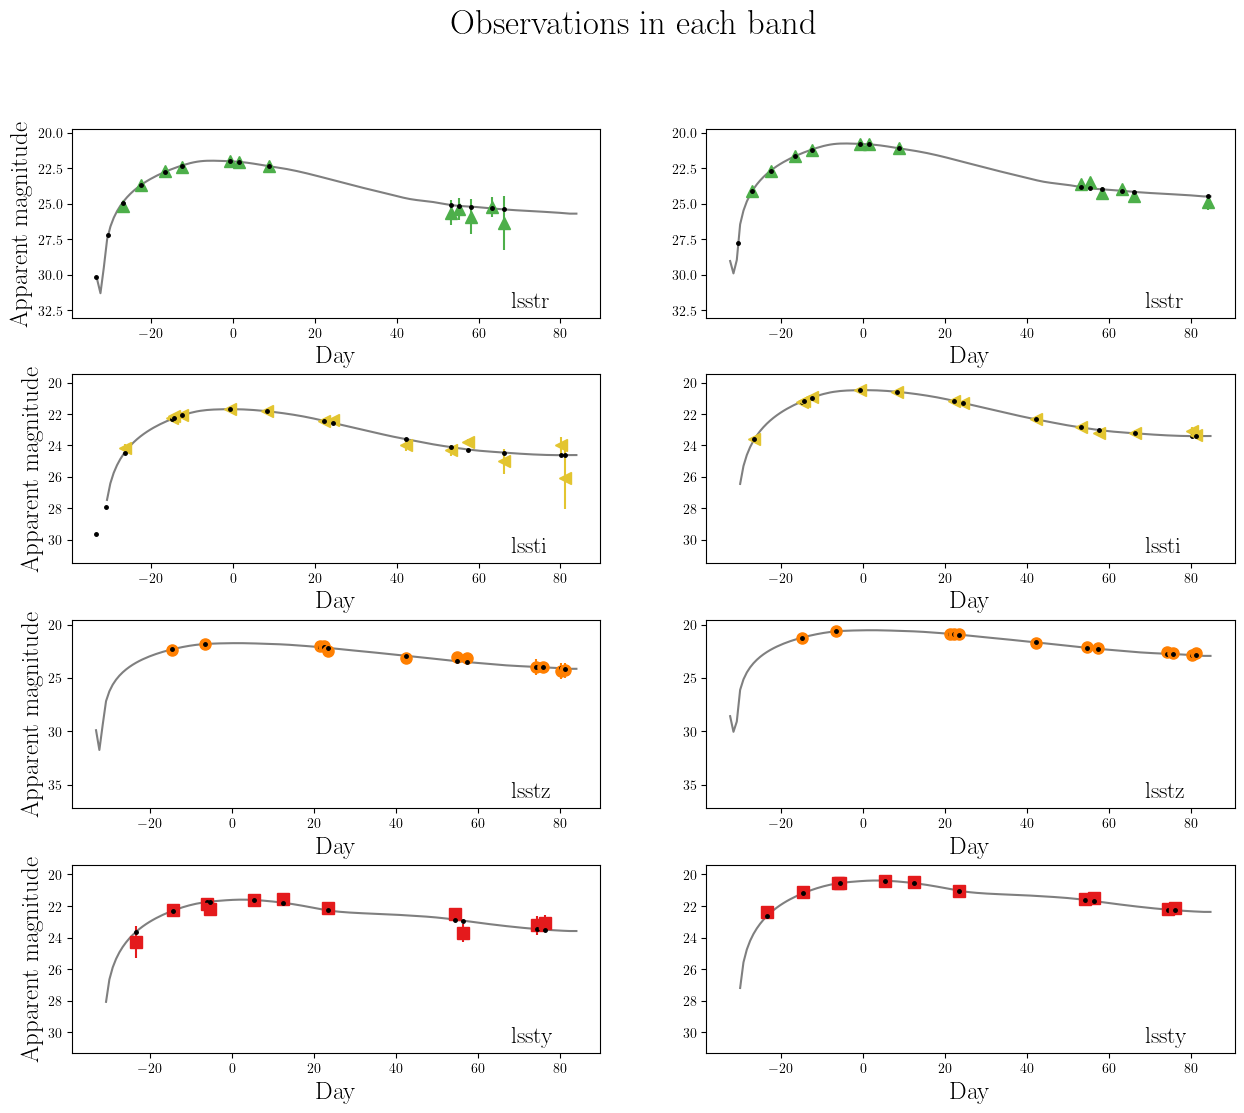

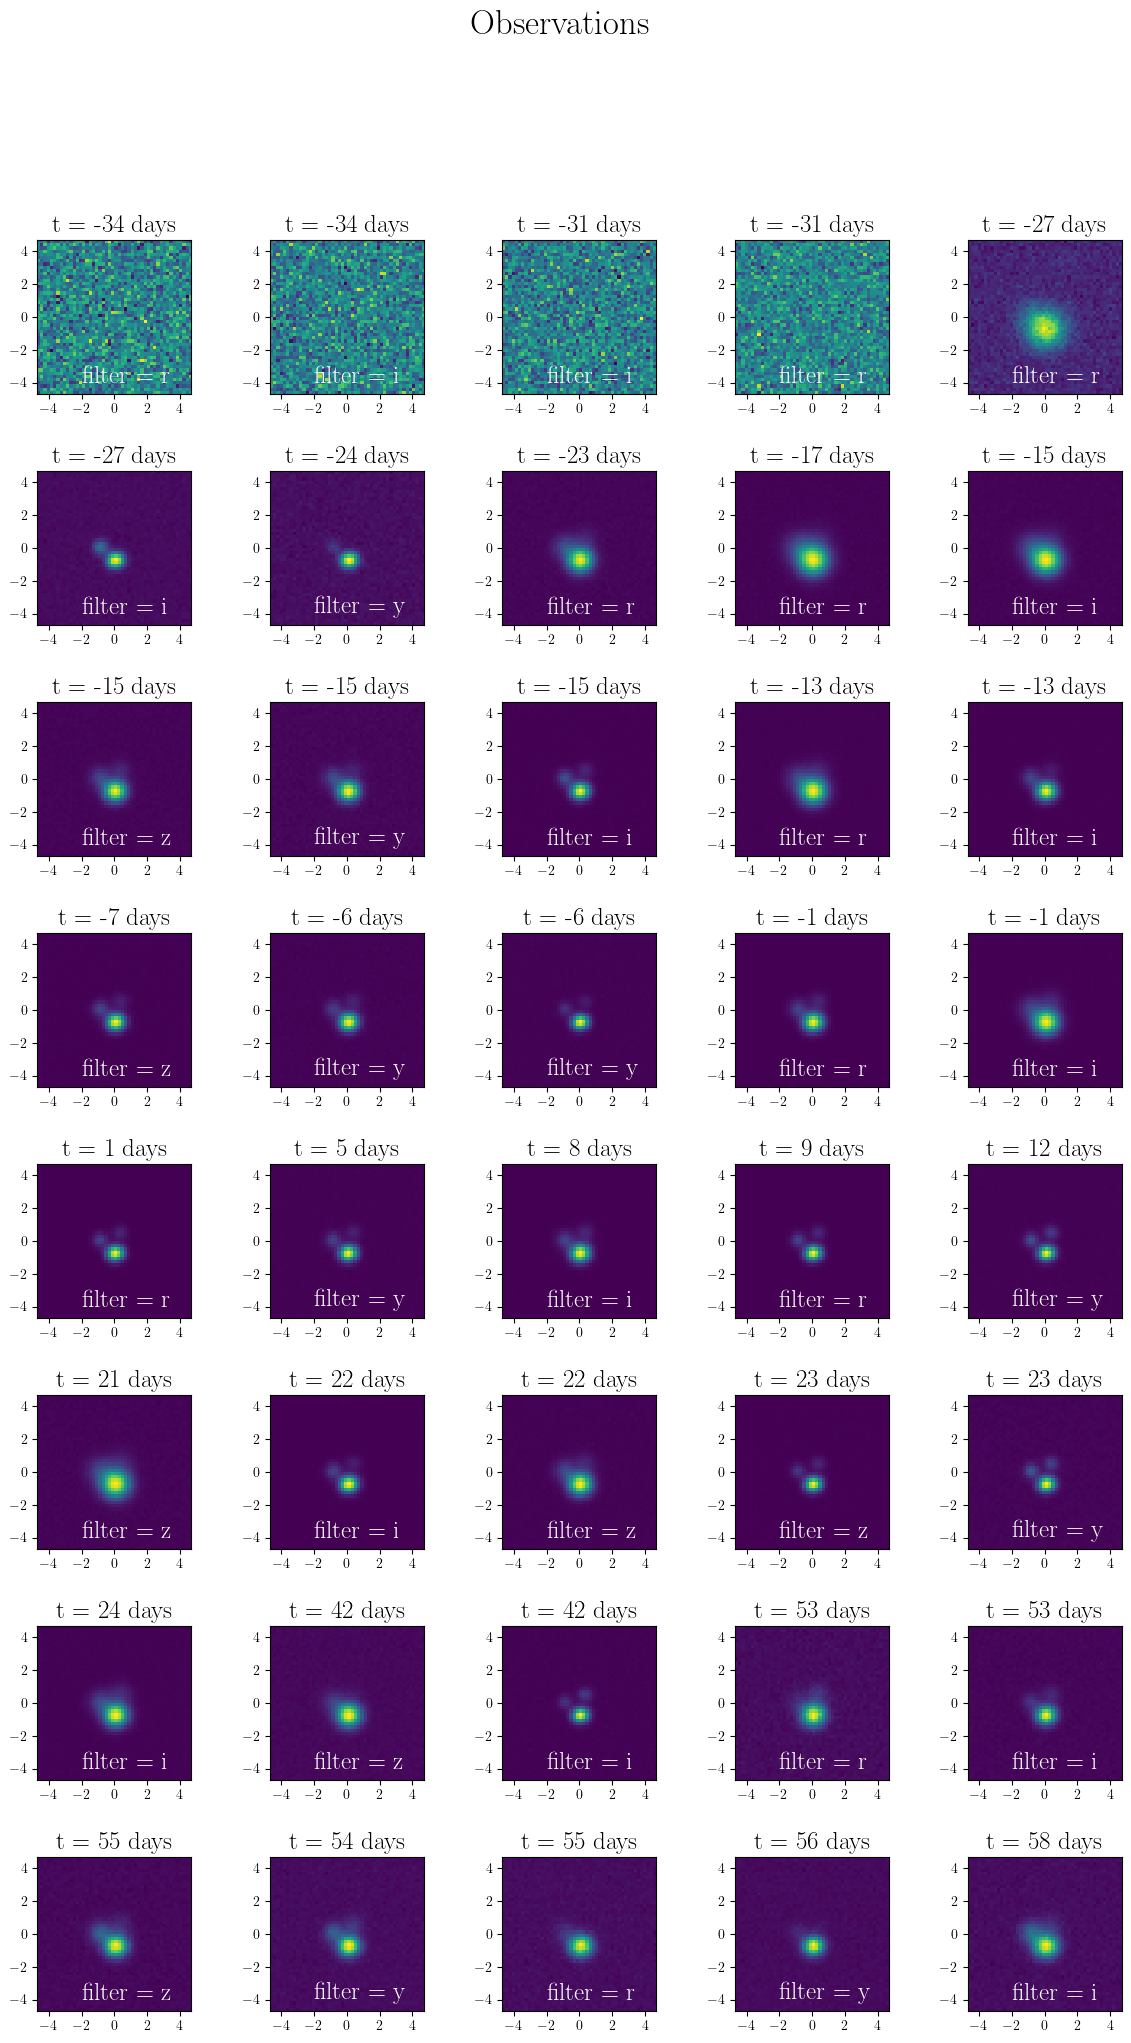

100%|████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.44s/it]

Done!
Simulating images took  10.0 seconds ( 0.0 hours) to complete.
Number of image-time series generated:  1
Number of configurations tried:  7
Number of attempts:  1695
 


100%|████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.24s/it]

                                         time_series  z_source    z_lens  \
0  [[[-2.018509054445068, 0.2234940500429418, 0.4...  0.678291  0.099592   

     H0  theta_E                                           obs_peak  \
0  67.8  0.77734  [[21.99605386427189, 20.764700239980442, 20.89...   

                                           obs_times  \
0  [-33.537484969776415, -33.50932397683937, -31....   

                                           obs_bands  \
0  [r, i, i, r, r, i, y, r, r, i, z, y, i, r, i, ...   

                                           model_mag  \
0  [[30.114765451758224, inf, inf, inf], [29.6319...   

                                             obs_mag  ...       obs_end  \
0  [[inf, inf, inf, inf], [inf, inf, inf, inf], [...  ...  61254.987038   

  mult_method_peak mult_method mag_method_peak mag_method  \
0             True        True           False      False   

                                      coords  \
0  [210.30650021855894, -0.7011595841065315

In [17]:
num_samples = 1               # Total number of lens systems to be generated  
batch_size = 1                # Number of lens systems that is saved together in a batch
batch = 1                     # Starting number of the batch
num_images = 4                # Choose between 2 (for doubles) and 4 (for quads)
obs_upper_limit = 200         # Upper limit of number of observations
obs_lower_limit = 5           # Lower limit of number of observations
fixed_H0 = True               # Bool, if False: vary H0. if True: fix H0 to 70 km/s/Mpc (for the evaluation set)
add_microlensing = False      # Bool, if False: Only macro magnification. if True: Add effects of microlensing

Show = True                   # Bool, if True: Show figures and print information about the lens systems
Save = False                  # Bool, if True: Save image time-series
path = "../processed_data/Baseline_v_3_0/" # Path to folder in which to save the results


df, timings = simulate_time_series_images(num_samples, batch_size, batch, num_images, add_microlensing, 
                                 obs_lower_limit, obs_upper_limit, fixed_H0, lsst, Show, Save, path)


In [ ]:
# ---------------------------------
telescope = 'LSST'
bandpasses = ['r', 'i', 'z', 'y']
num_samples = 1000
# ---------------------------------

lsst = Telescope(telescope, bandpasses, num_samples)

In [ ]:
num_samples = 1               # Total number of lens systems to be generated  
batch_size = 1                # Number of lens systems that is saved together in a batch
batch = 1                     # Starting number of the batch
num_images = 4                # Choose between 2 (for doubles) and 4 (for quads)
obs_upper_limit = 200         # Upper limit of number of observations
obs_lower_limit = 5           # Lower limit of number of observations
fixed_H0 = True               # Bool, if False: vary H0. if True: fix H0 to 70 km/s/Mpc (for the evaluation set)
add_microlensing = False      # Bool, if False: Only macro magnification. if True: Add effects of microlensing

Show = True                   # Bool, if True: Show figures and print information about the lens systems
Save = False                  # Bool, if True: Save image time-series
path = "../processed_data/Baseline_v_3_0/" # Path to folder in which to save the results


df, timings = simulate_time_series_images(num_samples, batch_size, batch, num_images, add_microlensing, 
                                 obs_lower_limit, obs_upper_limit, fixed_H0, lsst, Show, Save, path)

In [7]:
times = df['obs_times'][0]
modelmag = df['model_mag'][0]
obsmag = df['obs_mag'][0]
magerr = df['obs_mag_error'][0]
limmag = df['obs_lim_mag'][0]
snr = df['obs_snr'][0]

inf1 = times[obsmag[:,0] == np.inf]
inf2 = times[obsmag[:,1] == np.inf]

#print(times)
#print(" ")
#print(modelmag)

Text(0, 0.5, 'Apparent magnitude')

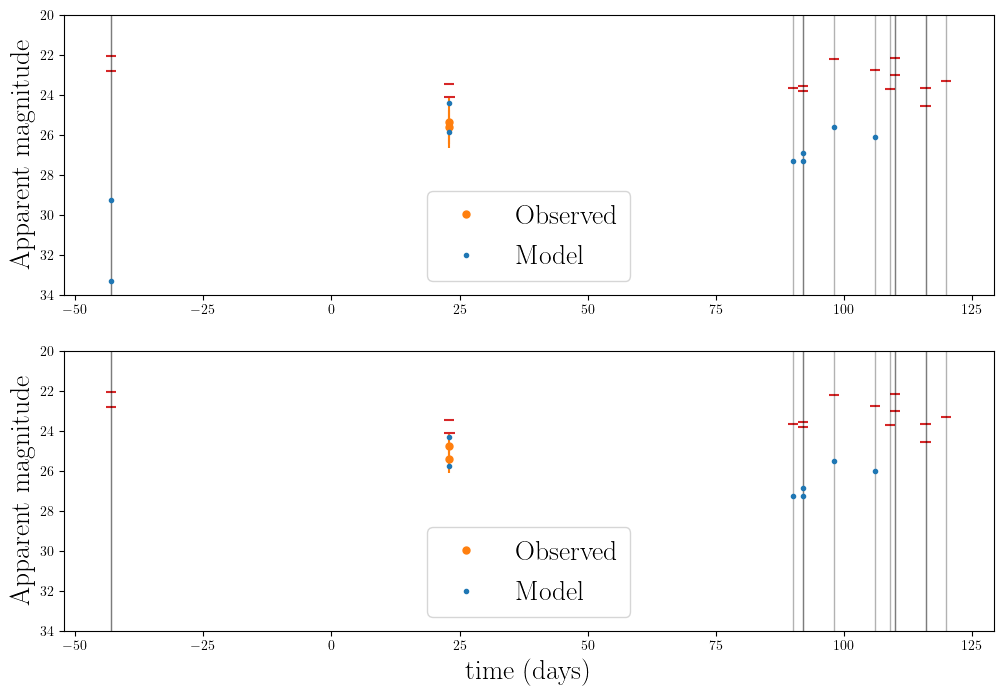

In [8]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

for i in inf1:
    ax[0].axvline(i, lw=1, color='black', alpha=0.3)
ax[0].plot(times, obsmag[:,0], '.', color='C1', ms=10, label='Observed')
ax[0].vlines(times, obsmag[:,0] - magerr[:,0], obsmag[:,0] + magerr[:,0], color='C1')
ax[0].plot(times, modelmag[:,0], '.', color='C0', label='Model')
for j in range(len(times)):
    ax[0].hlines(limmag[j], times[j] - 1, times[j] + 1, color='C3')
ax[0].set_ylim(34, 20)
ax[0].legend(loc='lower center', fontsize=20)
ax[0].set_ylabel("Apparent magnitude", fontsize=20)

for i in inf2:
    ax[1].axvline(i, lw=1, color='black', alpha=0.3)
ax[1].plot(times, obsmag[:,1], '.', ms=10, color='C1', label='Observed')
ax[1].vlines(times, obsmag[:,1] - magerr[:,1], obsmag[:,1] + magerr[:,1], color='C1')
ax[1].plot(times, modelmag[:,1], '.', color='C0', label='Model')
for j in range(len(times)):
    ax[1].hlines(limmag[j], times[j] - 1, times[j] + 1, color='C3')
ax[1].legend(loc='lower center', fontsize=20)
ax[1].set_ylim(34, 20)
ax[1].set_xlabel("time (days)", fontsize=20)
ax[1].set_ylabel("Apparent magnitude", fontsize=20)

# plt.savefig("../results/figures/data_gaps2.png", dpi=250)

Text(0, 0.5, 'Apparent magnitude')

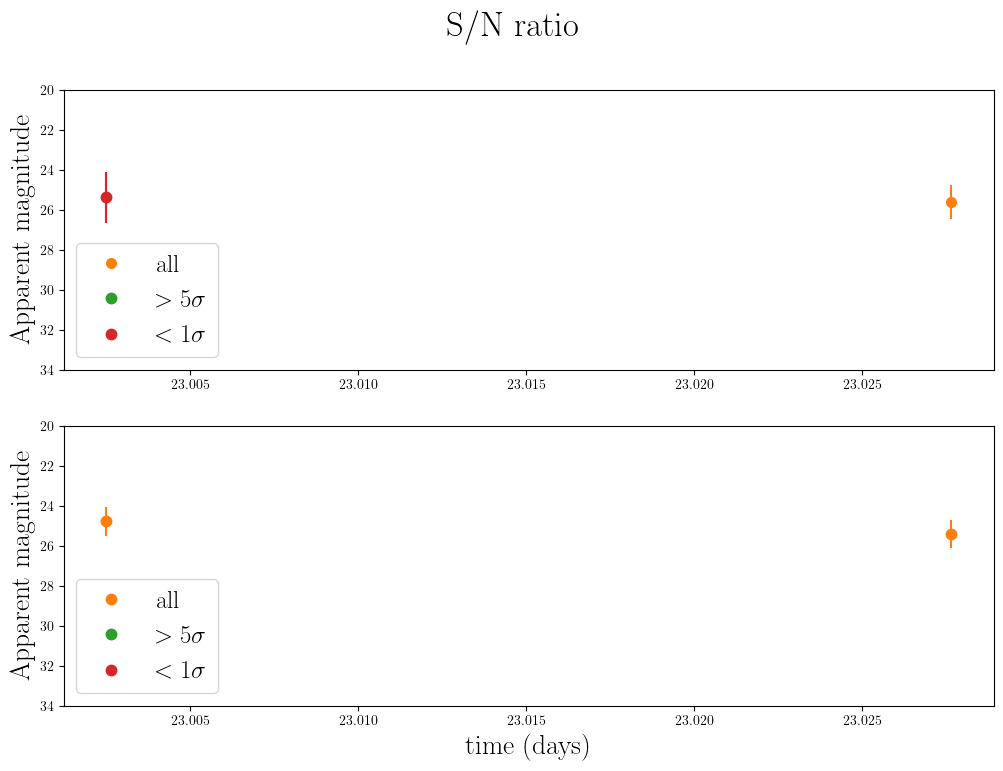

In [9]:
ind1_5s = snr[:,0] > 5
ind2_5s = snr[:,1] > 5
ind1_low = snr[:,0] < 1
ind2_low = snr[:,1] < 1

fig, ax = plt.subplots(2, 1, figsize=(12, 8))
fig.suptitle("S/N ratio", fontsize=25)

ax[0].plot(times, obsmag[:,0], '.', color='C1', ms=14, label='all')
ax[0].vlines(times, obsmag[:,0] - magerr[:,0], obsmag[:,0] + magerr[:,0], color='C1')
ax[0].vlines(times[ind1_5s], obsmag[:,0][ind1_5s] - magerr[:,0][ind1_5s], obsmag[:,0][ind1_5s] + magerr[:,0][ind1_5s], color='C2')
ax[0].vlines(times[ind1_low], obsmag[:,0][ind1_low] - magerr[:,0][ind1_low], obsmag[:,0][ind1_low] + magerr[:,0][ind1_low], color='C3')
ax[0].plot(times[ind1_5s], obsmag[:,0][ind1_5s], '.', color='C2', ms=15, label=r'$>$ 5$\sigma$')
ax[0].plot(times[ind1_low], obsmag[:,0][ind1_low], '.', color='C3', ms=15, label=r'$<$ 1$\sigma$')
#ax[0].plot(times, modelmag[:,0], '.', color='C0', label='Model')
ax[0].set_ylim(34, 20)
ax[0].legend(loc='lower left', fontsize=18)
ax[0].set_ylabel("Apparent magnitude", fontsize=20)

ax[1].plot(times, obsmag[:,1], '.', ms=15, color='C1', label='all')
ax[1].vlines(times, obsmag[:,1] - magerr[:,1], obsmag[:,1] + magerr[:,1], color='C1')
ax[1].vlines(times[ind2_5s], obsmag[:,1][ind2_5s] - magerr[:,1][ind2_5s], obsmag[:,1][ind2_5s] + magerr[:,1][ind2_5s], color='C2')
ax[1].vlines(times[ind2_low], obsmag[:,1][ind2_low] - magerr[:,1][ind2_low], obsmag[:,1][ind2_low] + magerr[:,1][ind2_low], color='C3')
ax[1].plot(times[ind2_5s], obsmag[:,1][ind2_5s], '.', color='C2', ms=15, label=r'$>$ 5$\sigma$')
ax[1].plot(times[ind2_low], obsmag[:,1][ind2_low], '.', color='C3', ms=15, label=r'$<$ 1$\sigma$')
#ax[1].plot(times, modelmag[:,1], '.', color='C0', label='Model')
ax[1].legend(loc='lower left', fontsize=18)
ax[1].set_ylim(34, 20)
ax[1].set_xlabel("time (days)", fontsize=20)
ax[1].set_ylabel("Apparent magnitude", fontsize=20)

#plt.savefig("../results/figures/snr.png", dpi=250)

In [10]:
print(snr[11])
print(obsmag[11])
print(limmag[11])
print(df['obs_bands'][0])

[0. 0. 0. 0.]
[inf inf inf inf]
22.13855374534093
['z' 'r' 'i' 'r' 'r' 'r' 'i' 'y' 'z' 'r' 'z' 'y' 'r' 'i' 'r']


In [11]:
print(df['obs_mag_unresolved'][0])

[        nan         nan 23.24356375 24.28725611         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan]


[50.         50.          0.17874771  0.25346273 50.         50.
 50.         50.         50.         50.         50.         50.
 50.         50.         50.        ]


(28.0, 20.0)

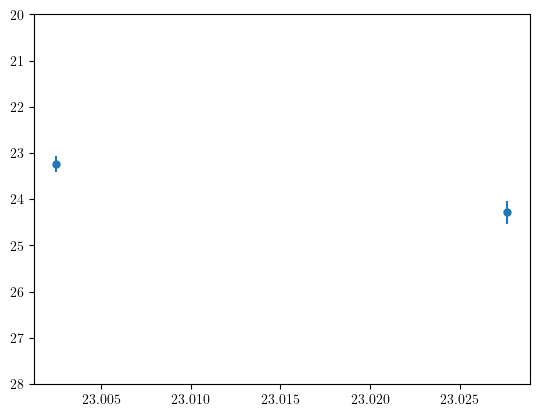

In [12]:
print(df['mag_unresolved_error'][0])

day = df['obs_times'][0]
mags = df['obs_mag_unresolved'][0]
error = df['mag_unresolved_error'][0]

plt.plot(day, mags, '.' , ms=10)
plt.vlines(day, mags - error, mags + error)
plt.ylim(28, 20)

[[25.59606032 25.41421875 25.43871515         inf]
 [25.37782307 24.77206662 23.77090727         inf]
 [        inf         inf         inf         inf]
 [        inf         inf         inf         inf]]
15 15
[-42.95814361 -42.94731812  23.00250608  23.0276464   89.96310442
  91.96183486  91.98601592  97.95598251 105.96780885 108.93722433
 109.89794334 109.91560986 115.86814413 115.8814025  119.91992154]
[[       nan        nan        nan        nan]
 [       nan        nan        nan        nan]
 [1.27627488 0.73053603 0.29052125        nan]
 [0.84612746 0.71564751 0.73197748        nan]
 [       nan        nan        nan        nan]
 [       nan        nan        nan        nan]
 [       nan        nan        nan        nan]
 [       nan        nan        nan        nan]
 [       nan        nan        nan        nan]
 [       nan        nan        nan        nan]
 [       nan        nan        nan        nan]
 [       nan        nan        nan        nan]
 [       nan        nan   

(28.0, 20.0)

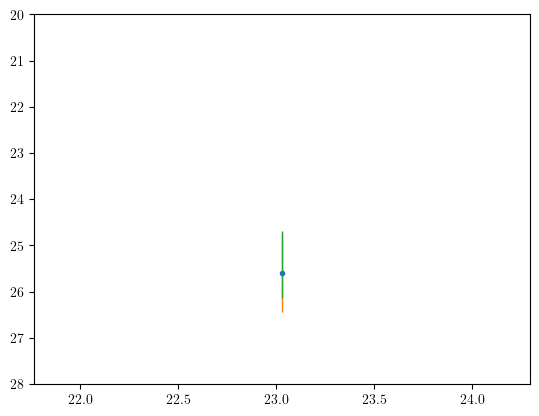

In [13]:
print(df['obs_peak'][0])

print(len(df['obs_times'][0]), len(df['obs_mag'][0]))
print(np.array(df['obs_times'][0]))
indices = np.array(df['obs_bands'][0]) == 'r'

print(df['obs_mag_error'][0])


for i in range(len(df['obs_times'][0])):
    print(df['obs_bands'][0][i], df['obs_mag'][0][i])

plt.figure()
plt.plot(np.array(df['obs_times'][0])[indices], np.array(df['obs_mag'][0])[:,0][indices], '.')
plt.errorbar(np.array(df['obs_times'][0])[indices], np.array(df['obs_mag'][0])[:,0][indices], 
             yerr=np.array(df['obs_mag_error'][0])[:,0][indices], lw=1)
plt.errorbar(np.array(df['obs_times'][0])[indices], np.array(df['obs_mag'][0])[:,1][indices], 
             yerr=np.array(df['obs_mag_error'][0])[:,1][indices], lw=1)

plt.ylim(28, 20)

### Calculate limiting magnitude including weather effects

In [14]:
fluxerr = np.array([6, 5, 4, 10])
flux = np.array([4, 45, 67, 20])

fluxcov = np.diag(fluxerr**2)
print(fluxcov)
# Add random (but correlated) noise to the fluxes
fluxchol = np.linalg.cholesky(fluxcov)
print(fluxchol)
print(" ")
randoms = np.random.randn(len(flux))
print(randoms)
print(fluxchol.dot(randoms))
newflux = flux + fluxchol.dot(randoms)

print(newflux)

[[ 36   0   0   0]
 [  0  25   0   0]
 [  0   0  16   0]
 [  0   0   0 100]]
[[ 6.  0.  0.  0.]
 [ 0.  5.  0.  0.]
 [ 0.  0.  4.  0.]
 [ 0.  0.  0. 10.]]
 
[-0.00707127  0.93165456 -0.72476205  1.09111049]
[-0.04242763  4.65827278 -2.8990482  10.91110486]
[ 3.95757237 49.65827278 64.1009518  30.91110486]


In [15]:
opsim_times = np.array([0, 0.4, 0.6, 0.9, 2, 2.8, 2.5, 8, 9, 9.9])
opsim_lim_mag = np.ones_like(opsim_times) * 20
opsim_filters = np.array(['i', 'r', 'i', 'r', 'i', 'i', 'i', 'i', 'u', 'u'])
IDs = np.arange(0, len(opsim_times))
print(IDs)

coadd_times, N_coadds, coadd_filters = [], [], []

ID_list = []

for t1 in range(len(opsim_times)):
    print(" ")
    print(t1)
    
    if IDs[t1] in ID_list:
        print("stop!")
        continue
    
    lim_mag_list = [opsim_lim_mag[t1]]
    times_list = [opsim_times[t1]]
    ID_list.append(IDs[t1])

    for t2 in range(t1+1, len(opsim_times)):

        # Same day?
        if opsim_times[t2] - opsim_times[t1] >= 1:
            break

        # Same filter?
        if opsim_filters[t1] == opsim_filters[t2]:
            lim_mag_list.append(opsim_lim_mag[t2])
            times_list.append(opsim_times[t2])
            ID_list.append(IDs[t2])
            print(t2)
            
    print(lim_mag_list)
    print(ID_list)
    coadd_times.append(np.mean(times_list))
    N_coadds.append(len(times_list))
    coadd_filters.append(opsim_filters[t1])
    
print(" ")
print("coadd_times: ", coadd_times)
print("N_coadds: ", N_coadds)
print("coadd_filters: ", coadd_filters)

[0 1 2 3 4 5 6 7 8 9]
 
0
2
[20.0, 20.0]
[0, 2]
 
1
3
[20.0, 20.0]
[0, 2, 1, 3]
 
2
stop!
 
3
stop!
 
4
5
6
[20.0, 20.0, 20.0]
[0, 2, 1, 3, 4, 5, 6]
 
5
stop!
 
6
stop!
 
7
[20.0]
[0, 2, 1, 3, 4, 5, 6, 7]
 
8
9
[20.0, 20.0]
[0, 2, 1, 3, 4, 5, 6, 7, 8, 9]
 
9
stop!
 
coadd_times:  [0.3, 0.65, 2.433333333333333, 8.0, 9.45]
N_coadds:  [2, 2, 3, 1, 2]
coadd_filters:  ['i', 'r', 'i', 'i', 'u']


In [16]:
import sncosmo

index = 8
zeropoint = df['zeropoint'][index]
skysig = np.array(df['skysig'][index])
mag_im = df['brightness_im'][index]
mag_im = mag_im[:len(zeropoint)]
bands = np.array(df['obs_bands'][index])

ab = sncosmo.get_magsystem('ab')
zpfluxes = np.array([ab.zpbandflux('lsst' + b) for b in bands])

print(bands)


KeyError: 'zeropoint'

In [ ]:
# Calculate limiting magnitude from sky noise and zeropoint
m_lim = zeropoint - 2.5*np.log10(5 * np.array(skysig))
print("Limiting magnitudes: ")
print(m_lim)

In [ ]:
# Convert image magnitudes back into fluxes
# flux_im = 10**(mag_im / -2.5) * zpfluxes

print(skysig[bands == 'r'])
print(skysig[bands == 'i'])
print(skysig[bands == 'z'])
print(skysig[bands == 'y'])

### Retrieve light curve observations

In [ ]:
print(min(df['brightness_unresolved'][0]))


times = np.array(df['obs_times'][0])
bands = np.array(df['obs_bands'][0])
mags = df['brightness_im'][0]
mags_unresolved = df['brightness_unresolved'][0]

print(times[-1] - times[0])
print(df['obs_end'][0] - df['obs_start'][0])
print(len(times))

mask_r = np.where(bands == 'r')
mask_i = np.where(bands == 'i')
mask_z = np.where(bands == 'z')
mask_y = np.where(bands == 'y')

print(df['brightness_im'][0][:,1][mask_y])

plt.figure()
plt.plot(times[mask_r], mags[:,0][mask_r], color='C0', label="r")
plt.plot(times[mask_r], mags[:,1][mask_r], color='C0')

plt.plot(times[mask_i], mags[:,0][mask_i], color='C1', label="i")
plt.plot(times[mask_i], mags[:,1][mask_i], color='C1')
plt.plot(times[mask_i], mags_unresolved[mask_i], '.', color='black')

plt.plot(times[mask_z], mags[:,0][mask_z], color='C2', label="z")
plt.plot(times[mask_z], mags[:,1][mask_z], color='C2')

plt.plot(times[mask_y], mags[:,0][mask_y], color='C3', label="y")
plt.plot(times[mask_y], mags[:,1][mask_y], color='C3')

plt.ylim(31, 22)
plt.ylabel("Apparent magnitude")
plt.xlabel("Time (days)")
plt.legend()


In [ ]:

"""
averages = [np.mean(t) for t in timings]
print(averages)
sums = [np.sum(t) for t in timings]
periods = [1,2,3,4,5,6,7,8,9,10,11]

plt.figure(1, figsize=(15, 5))
plt.plot(periods, averages[:11], '.', ms=10, color='midnightblue')

plt.figure(2, figsize=(15, 5))
plt.plot(periods, sums[:11], '.', ms=10, color='midnightblue')
"""

In [ ]:
"""
plt.figure(3)
plt.plot([1,2], sums[11:], '.', ms=20, color="C3")
print(sums[11], sums[12])
print(averages[11], averages[12])
print(averages[6])
"""

In [ ]:
# timings_200 = timings.copy()

In [ ]:
"""
mmaverages = [np.mean(t) for t in mmtimings]
mmsums = [np.sum(t) for t in mmtimings]
mmperiods = [1,2,3,4,5,6,7]
print(mmaverages)
print(mmsums)

plt.figure(4, figsize=(15, 5))
plt.plot(mmperiods, mmaverages, '.', ms=10, color='C1')

plt.figure(5, figsize=(15, 5))
plt.plot(mmperiods, mmsums, '.', ms=10, color='C1')
"""